/home/trofim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


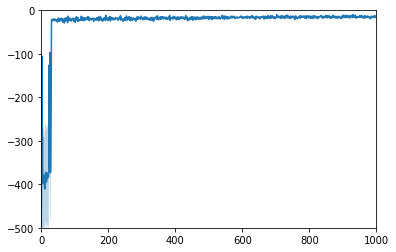

In [16]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt


"""
PointEnv from rllab
The goal is to control an agent and get it to the target located at (0,0).
At each timestep the agent gets its current location (x,y) as observation, 
takes an action (dx,dy), and is transitioned to (x+dx, y+dy).
"""
class PointEnv():
    def reset(self):
        self._state = np.random.uniform(-1, 1, size=(2,))
        state = np.copy(self._state)
        return state

    def step(self, action):
        action = np.clip(action, -1, 1)
        self._state = self._state + 0.1*action
        x, y = self._state
        reward = -(x**2 + y**2)**0.5 - 0.02*np.sum(action**2)
        done = abs(x) < 0.01 and abs(y) < 0.01
        next_state = np.copy(self._state)
        return next_state, reward, done


class Gauss_Policy():
    def __init__(self):
        self.action_dim = 2
        self.theta = 0.5 * np.ones(4)
        # theta here is a length 4 array instead of a matrix for ease of processing
        # Think of treating theta as a 2x2 matrix and then flatenning it, which gives us:
        # action[0] = state[0]*[theta[0], theta[1]]
        # action[1] = state[1]*[theta[2], theta[3]]

    def get_action_and_grad(self, state):
        # Exercise I.1:
        mean_act = np.array([np.dot(self.theta[:2], state), np.dot(self.theta[2:], state)])
        sampled_act = mean_act + 0.5 * np.random.randn(self.action_dim)
        grad_log_pi = np.ravel([state[0] * (sampled_act - mean_act), state[1] * (sampled_act - mean_act)])
        # end
        return sampled_act, grad_log_pi

# This function collects some trajectories, given a policy
def gather_paths(env, policy, num_paths, max_ts=100):
    paths = []
    for i in range(num_paths):
        ts = 0
        states = []
        act = []
        grads = []
        rwd = []
        done = False
        s = env.reset()
        while not done and ts<max_ts:
            a, grad_a = policy.get_action_and_grad(s)
            next_s, r, done = env.step(a)
            states += [s]
            act += [a]
            rwd += [r]
            grads += [grad_a]
            s = next_s
            ts += 1
        path = {'states': np.array(states),
                'actions': np.array(act),
                'grad_log_pi': np.array(grads),
                'rwd': np.array(rwd)}
        paths += [path]
    return paths


def baseline(paths):
    path_features = []
    for path in paths:
        s = path["states"]
        l = len(path["rwd"])
        al = np.arange(l).reshape(-1, 1) / 100.0
        path_features += [np.concatenate([s, s ** 2, al, al ** 2, al ** 3, np.ones((l, 1))], axis=1)]
    ft = np.concatenate([el for el in path_features])
    targets = np.concatenate([el['returns'] for el in paths])

    # Exercise I.2(a): Compute the regression coefficents
    coeffs = np.linalg.lstsq(ft, targets)[0]
    # Exercise I.2(b): Calculate the values for each state
    for i, path in enumerate(paths):
        path['value'] = np.dot(path_features[i], coeffs)

def process_paths(paths, discount_rate=1):
    grads = []
    for path in paths:
        # Exercise 1.3a: Implement the discounted return
        path['returns'] = scipy.signal.lfilter([1], [1, float(-discount_rate)], path['rwd'][::-1], axis=0)[::-1]
        # End
    baseline(paths)
    for path in paths:
        #path['value'] = np.zeros(len(path['value']))
        path['adv'] = path['returns'] - path['value']
        rets_for_grads = np.atleast_2d(path['adv']).T
        rets_for_grads = np.repeat(rets_for_grads, path['grad_log_pi'].shape[1], axis=1)
        path['grads'] = path['grad_log_pi']*rets_for_grads
        grads += [np.sum(path['grads'], axis=0)]
    grads = np.sum(grads, axis=0)/len(paths)
    return grads

env = PointEnv()
alpha = 0.05
num_itr = 1000
runs = 2
rwd = np.zeros((num_itr, runs))

for st in range(runs):
    policy = Gauss_Policy()
    # print(st)
    for i in range(num_itr):
        paths = gather_paths(env, policy, num_paths=5)
        rwd[i, st] = np.mean([np.sum(path['rwd']) for path in paths])
        grads = process_paths(paths, discount_rate=0.995)
        policy.theta += alpha * grads

mean_rwd = np.mean(rwd, axis=1)
sd_rwd = np.std(rwd, axis=1) / np.sqrt(10)
plt.plot(mean_rwd)
plt.fill_between(np.arange(len(mean_rwd)), mean_rwd + sd_rwd, mean_rwd - sd_rwd, alpha=0.3)
plt.ylim([-500, 0])
plt.xlim([0, num_itr])
plt.show()

In [18]:
policy.theta

array([-80.48984136, -10.9393676 , -80.40505059, -36.56996762])

In [19]:
paths = gather_paths(env, policy, num_paths=5)

In [28]:
for i in range(100):
    print(paths[0]['states'][i], paths[0]['actions'][i])

[ 0.93611794 -0.83935159] [-66.20804314 -43.74772684]
[ 0.83611794 -0.93935159] [-56.87611715 -33.34779365]
[ 0.73611794 -1.03935159] [-48.47096867 -20.70384978]
[ 0.63611794 -1.13935159] [-38.60112902  -8.85649245]
[ 0.53611794 -1.23935159] [-29.45846857   2.1655803 ]
[ 0.43611794 -1.13935159] [-22.4726849    6.07757113]
[ 0.33611794 -1.03935159] [-15.87014959  10.97212374]
[ 0.23611794 -0.93935159] [-7.79366843 15.53348072]
[ 0.13611794 -0.83935159] [-2.29614614 19.80164664]
[ 0.03611794 -0.73935159] [ 4.93881556 24.03107869]
[ 0.13611794 -0.63935159] [-4.12100983 13.53316901]
[ 0.03611794 -0.53935159] [ 3.2282454  14.95655092]
[ 0.13611794 -0.43935159] [-6.40288888  5.28900005]
[ 0.03611794 -0.33935159] [1.39565316 9.30033397]
[ 0.13611794 -0.23935159] [-7.8274818  -2.73280058]
[ 0.03611794 -0.33935159] [0.79988617 8.87502534]
[ 0.11610656 -0.23935159] [-6.53338468 -0.5846242 ]
[ 0.01610656 -0.29781401] [2.04103856 9.97790623]
[ 0.11610656 -0.19781401] [-7.10971918 -1.98343617]
[ 0.